<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Predicting-the-genetic-basis-of-metabolite-accumulation-and-depletion" data-toc-modified-id="Predicting-the-genetic-basis-of-metabolite-accumulation-and-depletion-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Predicting the genetic basis of metabolite accumulation and depletion</a></span></li><li><span><a href="#Producibility-analysis" data-toc-modified-id="Producibility-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Producibility analysis</a></span><ul class="toc-item"><li><span><a href="#Function-definitions" data-toc-modified-id="Function-definitions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Function definitions</a></span><ul class="toc-item"><li><span><a href="#FBA-of-iJR904-from-cobra" data-toc-modified-id="FBA-of-iJR904-from-cobra-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>FBA of iJR904 from cobra</a></span></li><li><span><a href="#FBA-of-iJR904-from-cvx" data-toc-modified-id="FBA-of-iJR904-from-cvx-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>FBA of iJR904 from cvx</a></span></li></ul></li><li><span><a href="#Naive-implementation-of-Metabolite-producibility-applied-to-biomass-components" data-toc-modified-id="Naive-implementation-of-Metabolite-producibility-applied-to-biomass-components-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Naive implementation of Metabolite producibility applied to biomass components</a></span><ul class="toc-item"><li><span><a href="#Cobrapy-implementation" data-toc-modified-id="Cobrapy-implementation-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Cobrapy implementation</a></span></li><li><span><a href="#Scrape-the-gene-order-and-metabolite-order-of-Figure-1" data-toc-modified-id="Scrape-the-gene-order-and-metabolite-order-of-Figure-1-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Scrape the gene order and metabolite order of Figure 1</a></span></li><li><span><a href="#Comparison-of-Cobrapy-implementation-with-Figure-1" data-toc-modified-id="Comparison-of-Cobrapy-implementation-with-Figure-1-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Comparison of Cobrapy implementation with Figure 1</a></span></li><li><span><a href="#Comparison-of-Cobrapy-implementation-with-Figure-2" data-toc-modified-id="Comparison-of-Cobrapy-implementation-with-Figure-2-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>Comparison of Cobrapy implementation with Figure 2</a></span></li></ul></li></ul></li></ul></div>

# Predicting the genetic basis of metabolite accumulation and depletion#

From

* Imielinski, M., Belta, C., Halasz, A., & Rubin, H. (2005). [Investigating metabolite essentiality through genome-scale analysis of Escherichia coli production capabilities](http://doi.org/10.1093/bioinformatics/bti245). Bioinformatics, 21(9), 2008–2016. 
* Imielinski, M., Klitgord, N., Belta, C., Klitgord, N., & Belta, C. (2008). [Investigating the genomic basis of metabolic robustness through in silico flux analysis](http://doi.org/10.1109/CDC.2008.4739459). In 2008 47th IEEE Conference on Decision and Control (pp. 793–798). IEEE. 

Notation: for $n,i\in{\mathbb N}$,we use $I_n$ to denote the $n\times n$ identity matrix, and $e^{n,i}\in{\mathbb R}^n$ to denote the $i$-th element of the Euclidean basis in $\mathbb R^n$. Given $m,n\in\mathbb N$, we use the notation $M=\{1,\ldots,m\}$ and $N=\{1,\ldots,n\}$.  For a set $C$, we use $|C$ to denote its cardinality. If $A\in\mathbb R^{m\times n}$ and $U\subset M$, then $A_U$ denotes the submatrix of $A$ containing the rows with indices in the set $U$. Therefore, if $x\in \mathbb R^n$, $i\in N$, and $U\subset N$, then $x_i$ and $x_U\in\mathbb R^{|U|}$ denote its $i$th component and the vector formed by taking components in set $U$, respectively.  Let $S\in\mathbb R^{m\times n}$ be the stoichiometric matrix, $x$ the set of $m$ metabolite concentrations, and $v$ the set of reaction fluxes. Then 

$$\begin{equation}
\dot{x} = Sv, v\geq 0
\end{equation}$$

$$\begin{equation}
Sv = 0, v\geq 0
\end{equation}$$

# Producibility analysis 

A metabolite $j\in M$ is called *producible* by the metabolic network (1) if the network can sustain its synthesis under the steady state and thermodynamic constraints in equation $(2)$.
To test producibility of metabolite $j$, we add a "fictitious" chemical reaction that uses metabolite $j$, and then test whether the network can produce strictly positive flux through this chemical reaction, while observing the steady state and thermodynamic constraints. Formally, this corresponds to an augmentation of the stoichiometry matrix $S$ with $e^{m,j}$ on the right, and the flux vector $v$ with $w\in\mathbb R$, $w \geq 0$ at the bottom. In other words, $w$ corresponds to the flux through the additional chemical reaction. To characterize the production capabilities of a metabolic network globally, we can add one test chemical reaction for each metabolite, and correspondingly augment the stoichiometry matrix $S$ with $I_m$ on the right and $v$ with a $w \in \mathbb R^n$, $w \geq 0$
at the bottom. We will denote the augmented matrix by
$\bar{S} \in\mathbb R^{m\times(n+m)}$ and the augmented vector by $\bar{v}\in\mathbb R^{n+m}$.
In this framework, producibility of metabolite $j\in M$ can be decided by solving the following LP:

$$\begin{equation}
\begin{array}{ll}
\underset{\bar{v}\in\mathbb R^{n+m}}{\max} & \bar{v}_{j+n}  \\
& \bar{S}\bar{v} = 0 \\
& \bar{v} \geq 0 \\
& \bar{v}_{j+n}\leq\alpha \\
\end{array}\end{equation}$$

where $\alpha$ is an arbitrary constant that keeps the problem bounded. If the optimal value of $(3)$ is zero, then metabolite $j$ is not producible.  Othewise metabolite $j$ is (potentially) producible.  To test the producibility of a metabolite under metabolic gene knockouts, one can simply add the equality constraints $\bar{v}_J = 0$ to (3) where $J$ is the set of reactions knocked out by the gene knockouts.

In order to asses the robustness of metabolism, we are interested in studying the producibility of each metabolite in a metabolic network under various metabolic gene knock- outs. With the framework we presented so far, this would imply solving a number of LP equal to the number of gene perturbations multiplied the number of metabolites. Since the size of each LP is in the order of thousands, and the number of gene perturbations is in the order of millions, such an approach would be infeasible computationally. In this paper, we propose the reduce the amount of computation by using both problem (3) and its dual, whose solutions are available simultaneously if an interior-point-type optimization method (such as the one implemented in SeDuMi [1]) is used. In the following we show that, in most of the cases, it is enough to solve one LP to decide the producibility of all metabolites. 

First, whenever we find a solution $\bar{v}$ of (3), we search it for all components for which $\bar{v}_{n+i}> 0$. If such a component is found, then we label metabolite $i$ as producible. Second, the dual of (3) is given by 

$$\begin{equation}
\begin{array}{ll}
\underset{g\in\mathbb R^m,s\in\mathbb R}{\min} & \alpha s\\
\text{subject to} & \bar{S}^Tg + se^{n+m,j+n}\leq e^{n+m,j+n} \\
& s\geq 0 \\
\end{array}
\end{equation}$$

where $s$ is a "slack" variable.  It is easy to see that the primal problem $(3)$ can only produce two optimal values of its objective: $0$ and $\alpha$.   Therefore the optimal value of the dual problem $(4)$ can only be $0$ or $\alpha$, which implies that every dual solution $g\in\mathbb R^m$ satisfies $\bar{S}^Tg\geq 0$. In our previous work, by employing a simple variation of Farkas' Lemma, we showed that $g$ satisfying 

$$\left\{\begin{array}{c}
\left(\bar{S}^Tg\right)_{n+i} >0 \\
\bar{S}^Tg \geq  0 \\
\end{array}\right\}$$

certifies the infeasibility of the set 

$$\left\{
\begin{array}{cc}
\bar{S}\bar{v} = 0, \\
\bar{v} = 0,  \\
\bar{v}_{n+i} > 0 \\
\end{array}
\right\}$$

Therefore, by a simple inspection fo the solution $g$ of the dual problem $(4)$, we can classify all metabolites $i$ for which $\left(\bar{S}^Tg\right)_{n+i} > 0$ as "non-producible".

## Function definitions

In [2]:
import cobra, libsbml, escher,numpy as np, pandas as pd
import scipy.sparse
import cvxpy as cvx
import cobra
import pandas as pd
from cobra.flux_analysis import single_gene_deletion

def makeS_and_rxn_bounds( model ):
    rxns = [rxn.id for rxn in model.reactions]
    mets = [met.name for met in model.metabolites] 
    S = cobra.util.create_stoichiometric_matrix(model, 
                                                array_type='DataFrame') 
                
    S.columns.name = 'reactions'
    S.index.name = 'metabolites'
    lower_bounds = pd.Series([rxn.lower_bound for rxn in model.reactions] , index=rxns)
    upper_bounds = pd.Series([rxn.upper_bound for rxn in model.reactions] , index= rxns)
    
    return S, lower_bounds, upper_bounds
def makeSbar( S ):
    m,n = S.shape
    I = np.eye(m)
    return scipy.sparse.lil_matrix(np.c_[S.value.toarray(), I])

def makeSbarAndE( S ):
    m,n = S.shape
    I = np.eye(m)
    Sbar = np.c_[S.value.toarray(), I]
    E = [np.squeeze(Sbar[j,:].T) for j in range(m)]
    return scipy.sparse.lil_matrix(Sbar), E

def makeBarBounds( m,lower_bounds, upper_bounds, alpha ):
    lower_bound_bar = np.r_[lower_bounds, np.zeros(m)]
    upper_bound_bar = np.r_[upper_bounds, np.ones(m)*alpha]
    return lower_bound_bar, upper_bound_bar
                                          
def augment_model_with_sink_rxns( model, metabolites ):
    new_model = model.copy()
    sink_rxns = dict([(metabolite.id, 
                       cobra.Reaction('Sink_{}'.format(metabolite.id)))
                             for metabolite in metabolites])
    new_model.add_reactions( sink_rxns.values() )
    for metabolite in metabolites:
        sink_rxns[metabolite.id].reaction = '{} -->'.format(metabolite.id)
    return new_model
def apply_rich_media( model ):
    for exchange in cobra.medium.boundary_types.find_boundary_types(model,'exchange'):
            exchange.lower_bound= -10
    return model

### FBA of iJR904 from cobra ###

In [7]:
ijr904 = cobra.io.load_json_model('iJR904.json')
solution = ijr904.optimize()
fluxes = pd.DataFrame({'Fluxes':solution.x_dict}, index=[r.id for r in ijr904.reactions])
fluxes.loc['BIOMASS_Ecoli']

Fluxes    0.921948
Name: BIOMASS_Ecoli, dtype: float64

### FBA of iJR904 from cvx

In [3]:
biomass_rxn = 'BIOMASS_Ecoli'

Sdf, lower_series, upper_series = makeS_and_rxn_bounds( ijr904 )
rxns = [rxn for rxn in Sdf.columns]
mets = [met for met in Sdf.index]
m,n = Sdf.shape
biomass = Sdf.columns.get_loc(biomass_rxn)
S = cvx.Constant(cobra.util.create_stoichiometric_matrix(ijr904, array_type='lil'))
v = cvx.Variable(n)

objective = cvx.Maximize(v[biomass] )
lower_bounds, upper_bounds = lower_series.values, upper_series.values

constraints = [S*v == 0,
               lower_bounds <= v,
               v <= upper_bounds]

problem = cvx.Problem(objective, constraints)
problem.solve(verbose=True)
cvx_fluxes = pd.DataFrame({'Flux':np.squeeze(np.asarray(v.value))}, index=rxns)
cvx_fluxes

-----------------------------------------------------------------
           OSQP v0.4.1  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 1075, constraints m = 2911
          nnz(P) + nnz(A) = 6653
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

iter   objective    pri res    dua res    rho        time
   1  -4.4805e-01   8.28e+00   1.02e-01   1.00e-01   6.64e-03s
 200  -8.2381e-01   9.22e-02   5.79e-03   1.00e-01   2.43e-02s
 400  -9.9621e-01   1.03e-01   2.10e-03   1.82e-02   4.23e-0

,Flux
12PPDt,1.306526e-02
2DGLCNRx,-4.468188e-03
2DGLCNRy,4.472779e-03
2DGULRx,-2.253078e-03
2DGULRy,6.687889e-03
3HCINNMH,-1.941550e-03
3HPPPNH,-1.398005e-03
4HTHRS,1.077562e-06
5DGLCNR,1.544766e-02
A5PISO,4.203810e-02


## Naive implementation of Metabolite producibility applied to biomass components

To validate the implementation, we compare our results against figure 1 in [Imielinski 2005](https://academic.oup.com/bioinformatics/article-lookup/doi/10.1093/bioinformatics/bti245)



### Cobrapy implementation

In [28]:
ijr904_augmented = augment_model_with_sink_rxns(ijr904, ijr904.reactions.BIOMASS_Ecoli.reactants  )
ijr904_augmented = apply_rich_media(ijr904_augmented)
metabolite_production = {}
kos = pd.DataFrame()
for reactant in ijr904_augmented.reactions.BIOMASS_Ecoli.reactants:
    with ijr904_augmented:
        ijr904_augmented.objective = 'Sink_{}'.format(reactant.id)
        metabolite_production[('wild-type', reactant.id)] = ijr904_augmented.optimize().objective_value
        ko = single_gene_deletion(ijr904_augmented)
        kos[reactant.id] = ko['growth']

kos.to_csv('cobra_naive_growth_rich_media.tab',sep='\t')
kos

,5mthf_c,accoa_c,ala__L_c,amp_c,arg__L_c,asn__L_c,asp__L_c,atp_c,clpn_EC_c,coa_c,...,ptrc_c,ser__L_c,spmd_c,succoa_c,thr__L_c,trp__L_c,tyr__L_c,udpg_c,utp_c,val__L_c
ids,,,,,,,,,,,,,,,,,,,,,
(b2978),9.148439e+01,13.333333,420.0,40.0,105.0,210.000000,420.0,13.333333,0.4,13.333333,...,210.0,420.0,150.000000,13.333333,420.000000,201.812291,275.201015,20.0,13.333333,430.0
(b1872),9.096151e+01,13.333333,420.0,40.0,105.0,210.000000,420.0,13.333333,0.4,13.333333,...,210.0,420.0,149.933165,13.333333,419.448055,200.950568,273.891371,20.0,13.333333,430.0
(b0186),9.148439e+01,13.333333,420.0,40.0,105.0,210.000000,420.0,13.333333,0.4,13.333333,...,210.0,420.0,150.000000,13.333333,420.000000,201.812291,275.201015,20.0,13.333333,430.0
(b2797),9.148439e+01,13.333333,420.0,40.0,105.0,210.000000,420.0,13.333333,0.4,13.333333,...,210.0,420.0,150.000000,13.333333,420.000000,201.812291,275.201015,20.0,13.333333,430.0
(b0061),9.148439e+01,13.333333,420.0,40.0,105.0,210.000000,420.0,13.333333,0.4,13.333333,...,210.0,420.0,150.000000,13.333333,420.000000,201.812291,275.201015,20.0,13.333333,430.0
(b2677),9.148439e+01,13.333333,420.0,40.0,105.0,210.000000,420.0,13.333333,0.4,13.333333,...,210.0,420.0,150.000000,13.333333,420.000000,201.812291,275.201015,20.0,13.333333,430.0
(b1851),9.148439e+01,13.333333,420.0,40.0,105.0,210.000000,420.0,13.333333,0.4,13.333333,...,210.0,420.0,150.000000,13.333333,420.000000,201.812291,275.201015,20.0,13.333333,430.0
(b4232),9.148439e+01,13.333333,420.0,40.0,105.0,210.000000,420.0,13.333333,0.4,13.333333,...,210.0,420.0,150.000000,13.333333,420.000000,201.812291,275.201015,20.0,13.333333,430.0
(b0029),9.148439e+01,13.333333,420.0,40.0,105.0,210.000000,420.0,13.333333,0.4,13.333333,...,210.0,420.0,150.000000,13.333333,420.000000,201.812291,275.201015,20.0,13.333333,430.0


### Scrape the gene order and metabolite order of Figure 1

In [34]:
fig_1_gene_order = """
ndk
adk
trxB
coaD
coaA
gmk
nadD
yfjB
glgA
glgC
pgsA
cls
tmk
ribF
ribD
ribA
ribB
ribE
ribH
folA
folE
pabC
pabA
folC
folK
folP
aroC
metF
pabB
aroA
folB
aroD
aroB
accD
accB
cdsA
accA
fabG
accC
fabD
fabI
fabA
fabZ
fabB
plsC
fabF
plsB
pssA
psd
lpxB
rfaG
lpxC
rfaL
lpxA
rfaJ
lpxD
lpxK
ushA
rfaE
rfaD
rfaF
rfaI
kdsA
kdsB
gmhA
msbB
kdtA
yaeD
rfaC
lpxL
glmU
mrsA
murB
murD
murG
murC
murA
murE
murF
murI
mraY
""".split('\n')


In [33]:
print('\n'.join([metab.id for metab in ijr904.reactions.BIOMASS_Ecoli.reactants]))

5mthf_c
accoa_c
ala__L_c
amp_c
arg__L_c
asn__L_c
asp__L_c
atp_c
clpn_EC_c
coa_c
ctp_c
cys__L_c
datp_c
dctp_c
dgtp_c
dttp_c
fad_c
gln__L_c
glu__L_c
gly_c
glycogen_c
gtp_c
h2o_c
his__L_c
ile__L_c
leu__L_c
lps_EC_c
lys__L_c
met__L_c
nad_c
nadh_c
nadp_c
nadph_c
pe_EC_c
peptido_EC_c
pg_EC_c
phe__L_c
pro__L_c
ps_EC_c
ptrc_c
ser__L_c
spmd_c
succoa_c
thr__L_c
trp__L_c
tyr__L_c
udpg_c
utp_c
val__L_c


In [48]:
fig_1_metab_order = '''
lps_EC_c
pe_EC_c
ps_EC_c
clpn_EC_c
pg_EC_c
5mthf_c
peptido_EC_c
fad_c
glycogen_c
succoa_c
coa_c
accoa_c
dgtp_c
gtp_c
dttp_c
dctp_c
utp_c
udpg_c
ctp_c
nadph_c
nadp_c
nadh_c
nad_c
datp_c
adp_c
atp_c
'''.split('\n')

In [54]:
genes = pd.read_table('genes.tab', na_values='NIL').dropna().set_index('Blattner')
genes.index = [frozenset({gene}) for gene in genes.index]
kos['gene'] = genes['name']
oks = kos[kos<1e-3].set_index('gene').T.loc[fig_1_metab_order,
                                           fig_1_gene_order].fillna(1)
oks.shape

/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/pandas/core/indexing.py:1472 FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


(28, 83)

### Comparison of Cobrapy implementation with Figure 1

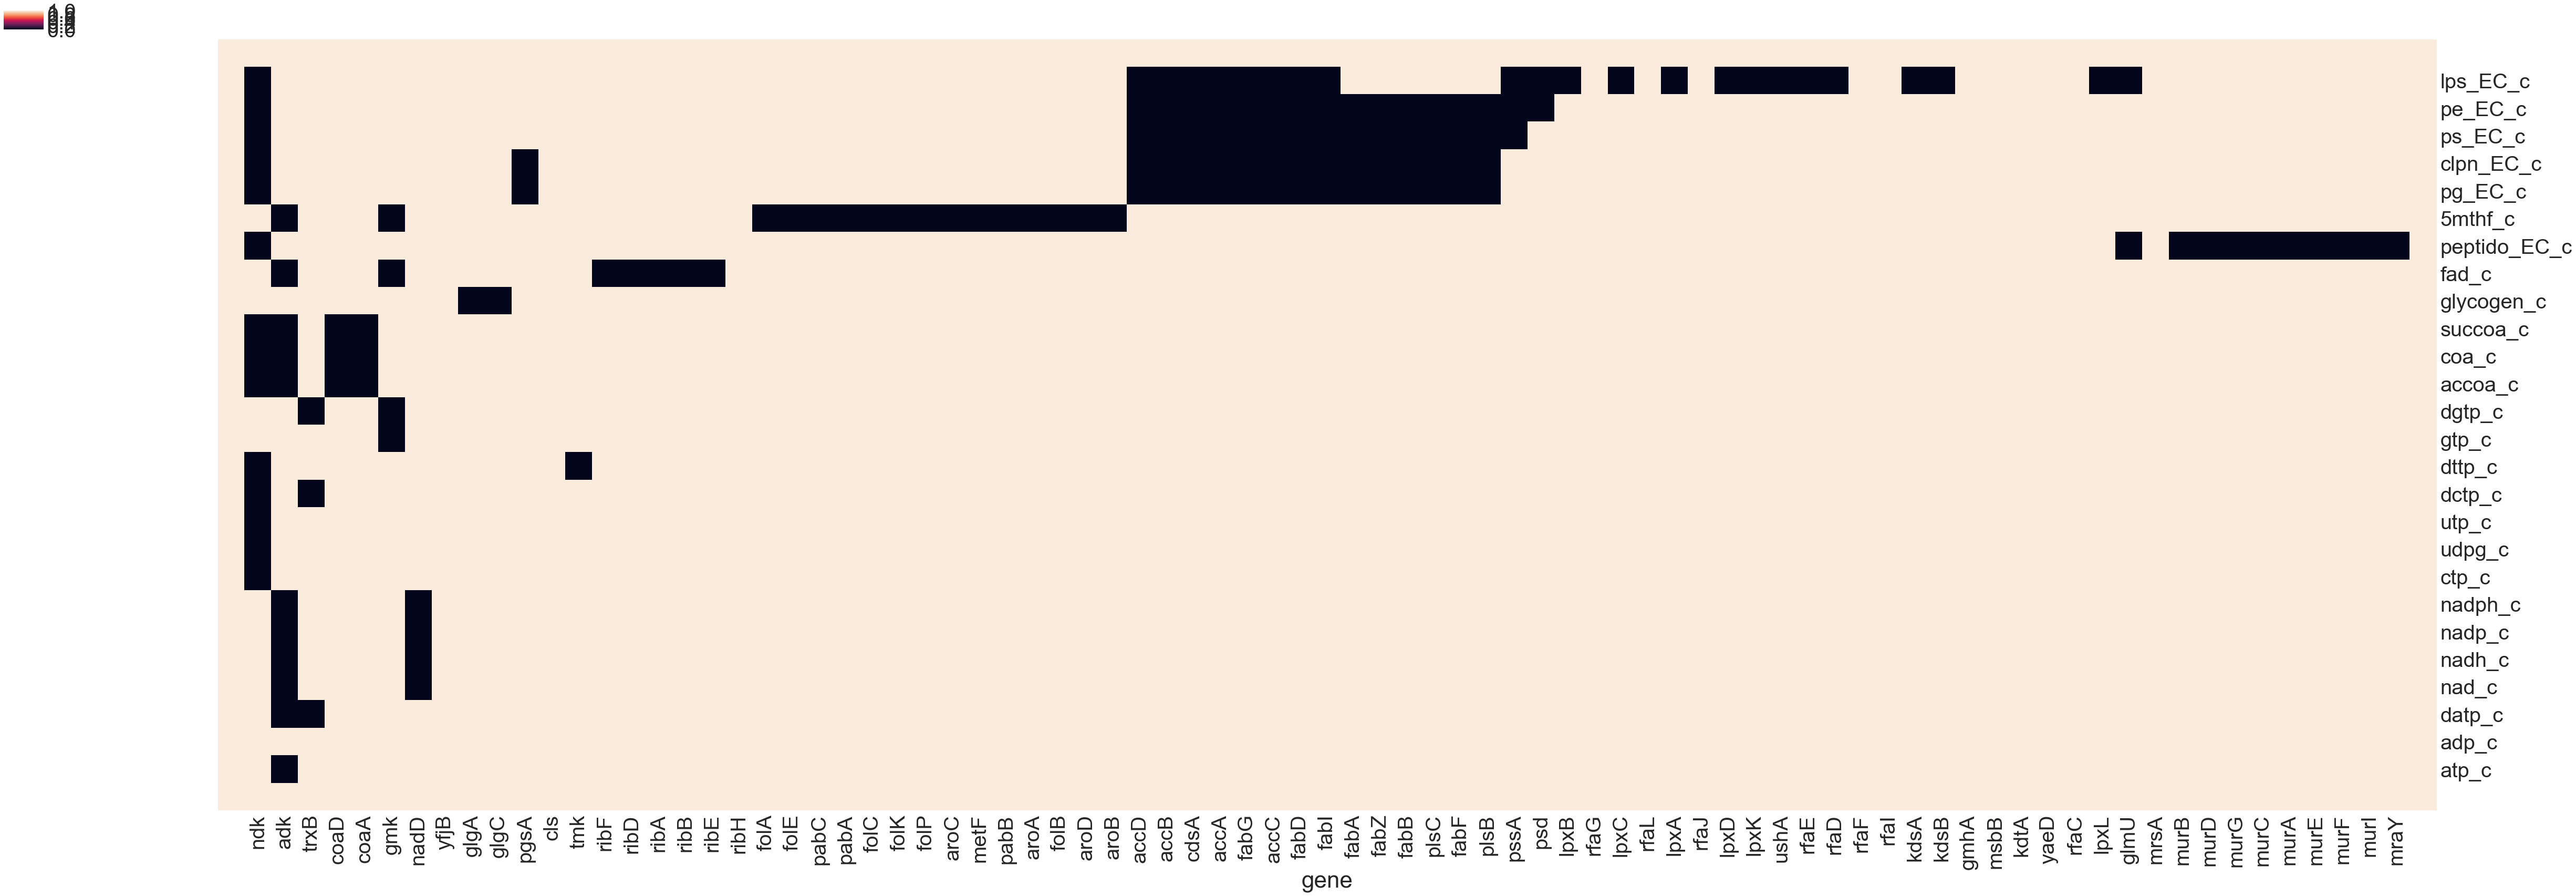

In [56]:
%matplotlib inline
import seaborn as sns; sns.set(color_codes=True)
sns.set(font_scale=4)
g = sns.clustermap(oks,
                   figsize=oks.T.shape,
                  row_cluster=False,
                  col_cluster=False)
g.savefig('metabolite_producibility_cobra_rich_media.png')

![Figure 1](Figure1_Bioinformatics_2005.png)

### Comparison of Cobrapy implementation with Figure 2

In [22]:
fig_2_gene_order = pd.read_table('Figure2_gene_order.tab')['Genes'].values
fig_2_gene_order

array(['ndk', 'accD', 'accB', 'accA', 'accC', 'fabD', 'fabG', 'fabI',
       'mrsA', 'glmU', 'fabA', 'fabZ', 'fabB', 'fabF', 'plsC', 'plsB',
       'cdsA', 'pldA', 'adk', 'kdsA', 'lpxA', 'lpxC', 'lpxD', 'ushA',
       'lpxB', 'lpxK', 'dsB', 'kdtA', 'dxs', 'dxr', 'ispF', 'ispE',
       'ispD', 'gcpE', 'lytB', 'ispA', 'uppS', 'gmk', 'pgsA', 'lpxP',
       'msbB', 'lpxL', 'murB', 'murC', 'murA', 'murI', 'murD', 'murE',
       'murF', 'mraY', 'murG', 'gltX', 'cls', 'ribB', 'mgsA', 'thiL',
       'wecA', 'prsA', 'pssA', 'psd', 'metK', 'astA', 'tmk'], dtype=object)

In [26]:
fig_2_metab_order = (pd.read_table('Figure2_metabolite_order.tab')['Metabolites'] + '_c').values
figure2_mets = [ijr904.metabolites.get_by_id(met)
                for met in fig_2_metab_order]
figure2_mets

[<Metabolite uaagmda_c at 0x1152f2080>,
 <Metabolite uagmda_c at 0x1152f2198>,
 <Metabolite lipa_c at 0x1152bbc18>,
 <Metabolite kdo2lipid4p_c at 0x1152bb908>,
 <Metabolite lipa_c at 0x1152bbc18>,
 <Metabolite kdo2lipid4L_c at 0x1152bb898>,
 <Metabolite kdo2lipid4_c at 0x1152bb8d0>,
 <Metabolite kdolipid4_c at 0x1152bb9b0>,
 <Metabolite lipidA_c at 0x1152bbc88>,
 <Metabolite lipidAds_c at 0x1152bbcc0>,
 <Metabolite lipidX_c at 0x1152bbcf8>,
 <Metabolite u23ga_c at 0x1152e4f98>,
 <Metabolite u3hga_c at 0x1152f2048>,
 <Metabolite u3aga_c at 0x1152e4fd0>,
 <Metabolite ttdcea_c at 0x1152e4ef0>,
 <Metabolite hdcea_c at 0x1152bb0f0>,
 <Metabolite ocdcea_c at 0x1152c9c50>,
 <Metabolite agpg_EC_c at 0x115285400>,
 <Metabolite pe_EC_c at 0x1152d70b8>,
 <Metabolite ps_EC_c at 0x1152d7908>,
 <Metabolite clpn_EC_c at 0x115293320>,
 <Metabolite pg_EC_c at 0x1152d7198>,
 <Metabolite pgp_EC_c at 0x1152d71d0>,
 <Metabolite cdpdag_EC_c at 0x115293080>,
 <Metabolite 12dgr_EC_c at 0x115267390>,
 <Metabol

In [ ]:
ijr904_figure2 = apply_rich_media(augment_model_with_sink_rxns(ijr904, figure2_mets  ))
metabolite_production = {}
kos = pd.DataFrame()
for reactant in figure2_mets:
    with ijr904_figure2:
        ijr904_figure2.objective = 'Sink_{}'.format(reactant.id)
        metabolite_production[('wild-type', reactant.id)] = ijr904_figure2.optimize().objective_value
        ko = single_gene_deletion(ijr904_figure2)
        kos[reactant.id] = ko['growth']

kos.to_csv('Figure2_cobra_naive_growth_rich_media.tab',sep='\t')

In [35]:
genes = pd.read_table('genes.tab', na_values='NIL').dropna().set_index('Blattner')
genes.index = [frozenset({gene}) for gene in genes.index]
kos['gene'] = genes['name']
missing_genes = [list(k)[0] for k in kos[kos['gene'].isna()].index]
print('\n'.join(missing_genes))

b1898
b3112
b3767
b3692
b2978
b3111
b1417
b3768
b1899
b1416
b4228
b4229


In [36]:
genes

,name
(b0765),modC
(b0808),ybiO
(b1856),mepM
(b3950),frwB
(b3410),feoC
(b4349),hsdM
(b1604),ydgH
(b0445),ybaE
(b3542),dppC
(b3391),hofQ


In [27]:
oks = kos[kos<1e-3].set_index('gene').T.loc[fig_2_metab_order,
                                           fig_2_gene_order].fillna(1)
oks.shape

/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/pandas/core/indexing.py:1472 FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


(67, 63)

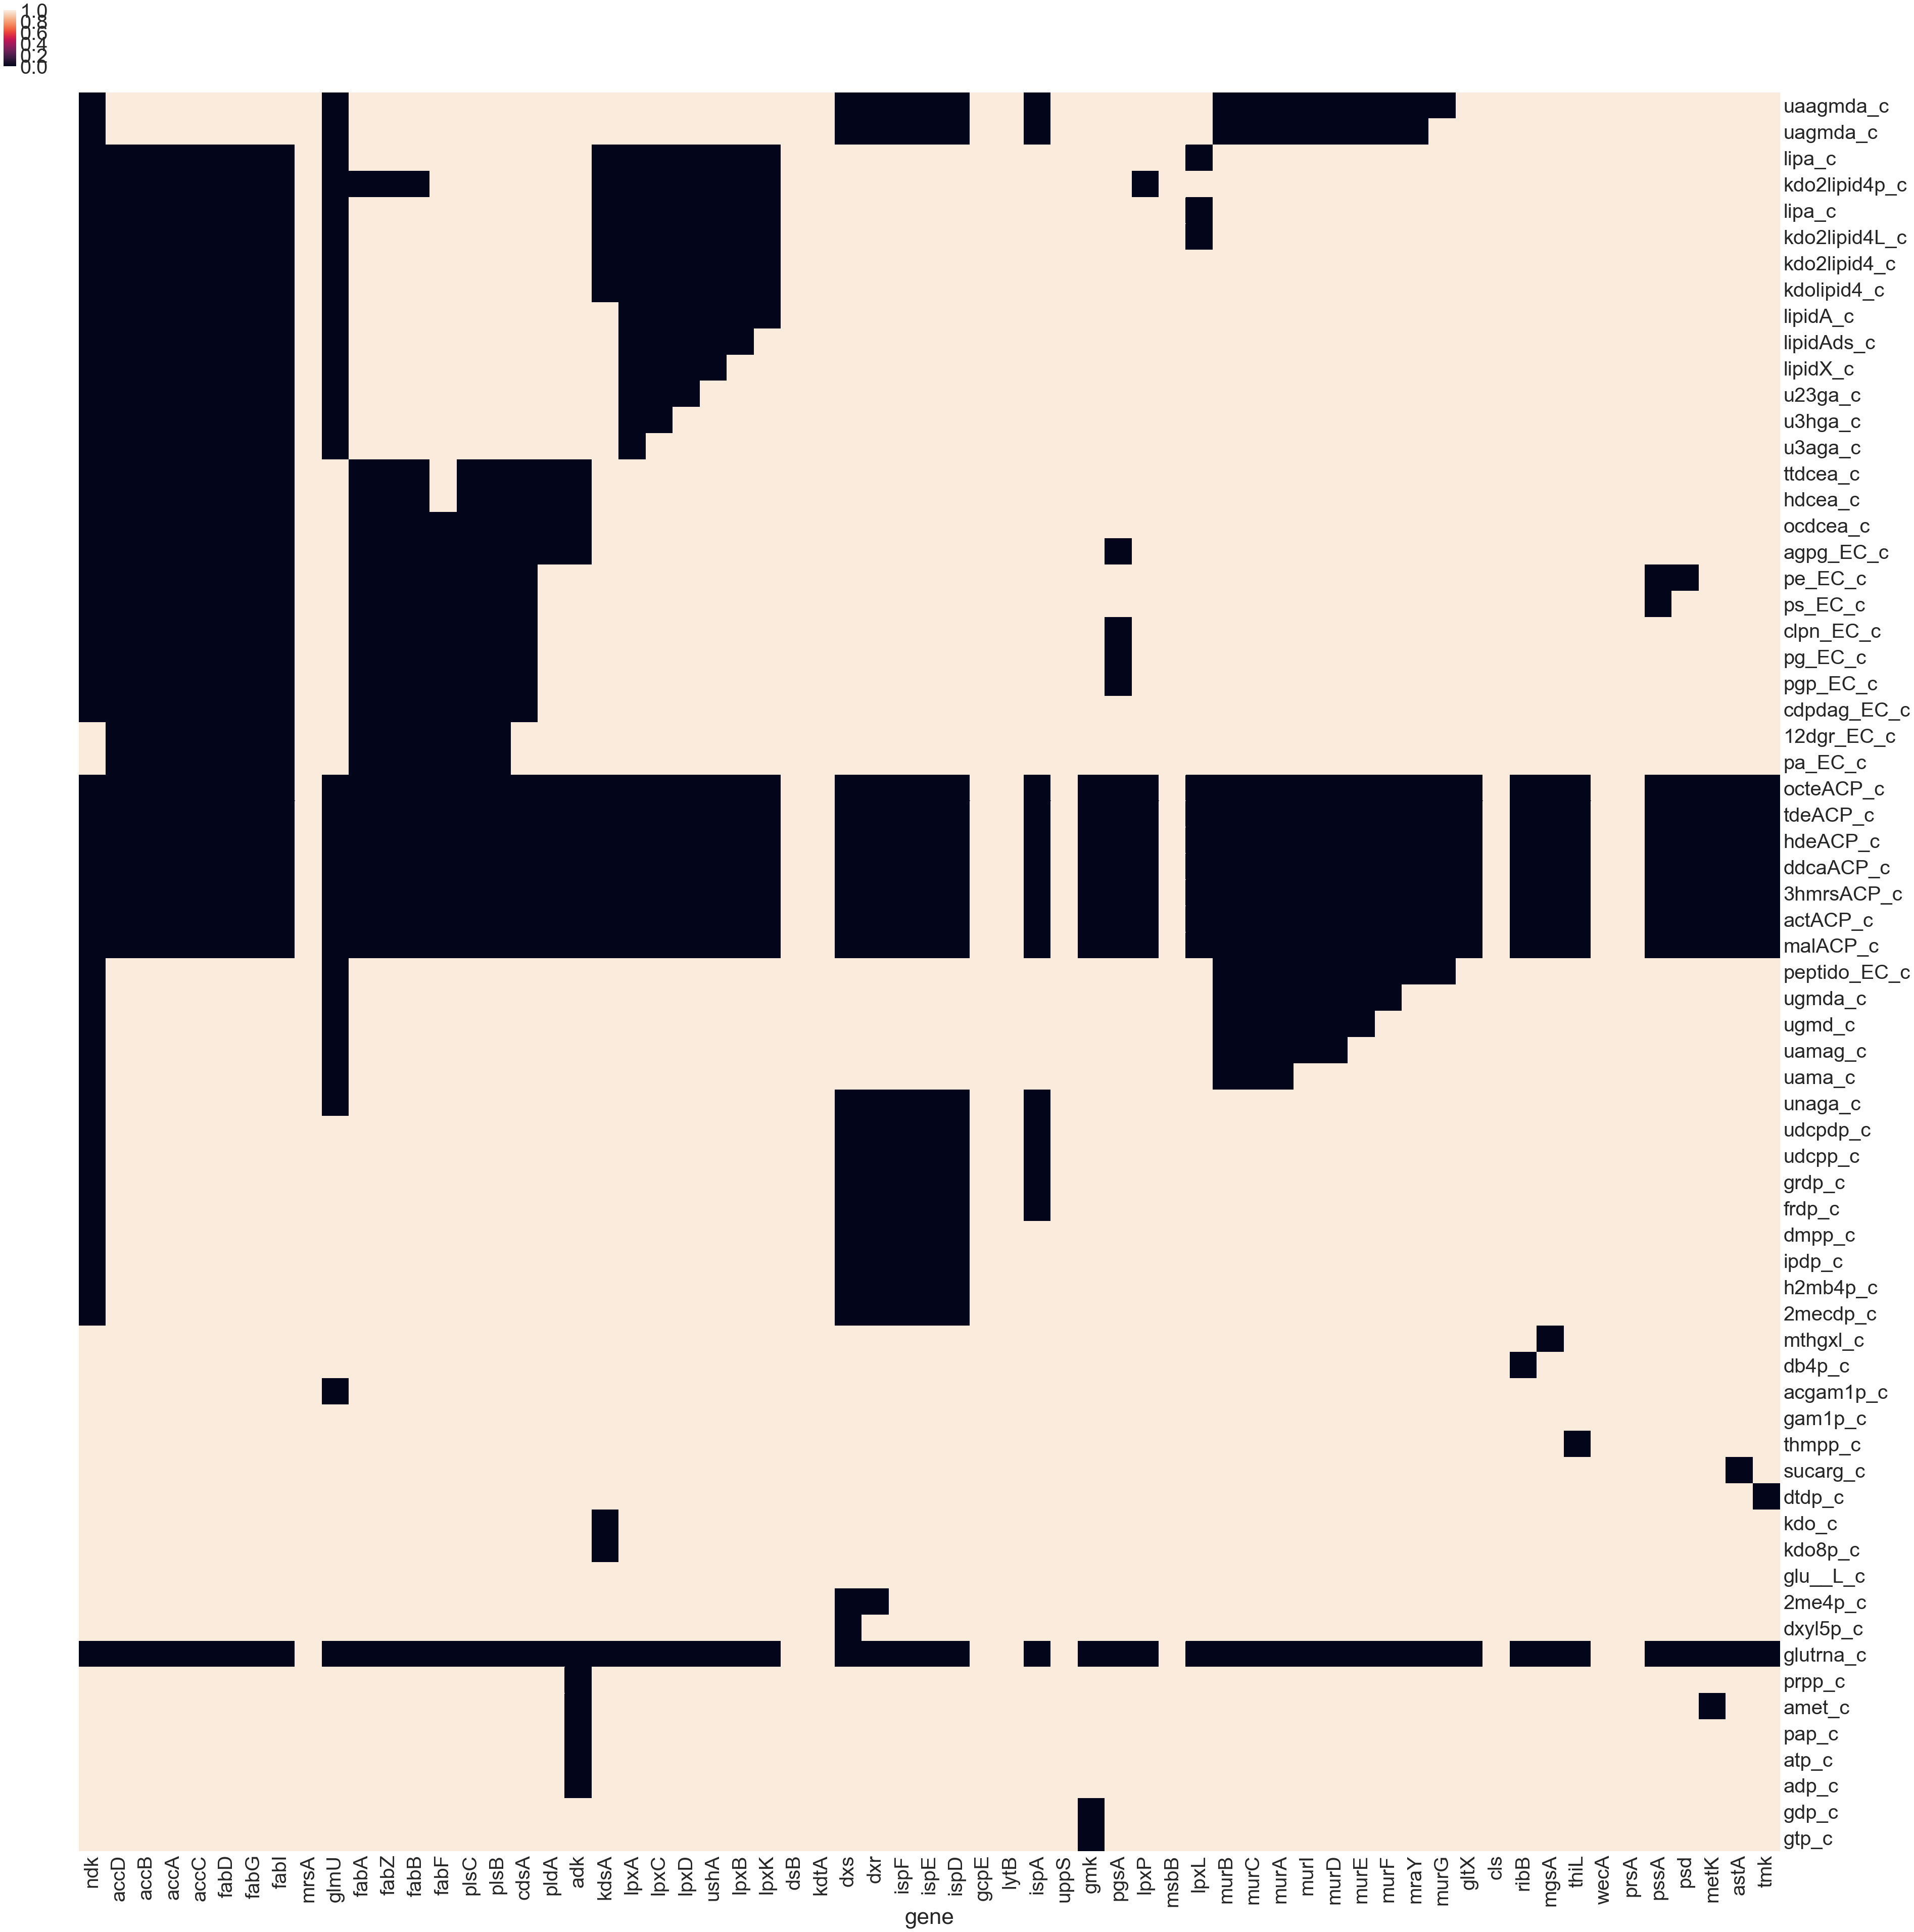

In [28]:
%matplotlib inline
import seaborn as sns; sns.set(color_codes=True)
sns.set(font_scale=4)
g = sns.clustermap(oks,
                   figsize=oks.T.shape,
                  row_cluster=False,
                  col_cluster=False)
g.savefig('Figure2_metabolite_producibility_cobra_rich_media.png')

![Figure2_Bioinformatics_2005.png](Figure2_Bioinformatics_2005.png)